In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

In [8]:
def train_eval(dataset_path):
    # Loading dataset
    data = pd.read_csv(dataset_path, parse_dates=['Datetime'], index_col='Datetime')

    # Data preprocessing
    data = data.dropna()  # Handle missing values if any

    # We are going to predict 'Global_active_power' using other features
    target = 'Global_active_power'
    features = data.drop(columns=[target])

    # Creating lag features (shifted values)
    lags = 3  # Number of lag features you want
    for i in range(1, lags + 1):
        data[f'{target}_lag_{i}'] = data[target].shift(i)

    # Drop missing rows created due to shifting
    data = data.dropna()

    # Define X and y
    X = data.drop(columns=[target])
    y = data[target]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Initialize models
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb_model = XGBRegressor(n_estimators=100, random_state=42)

    # Fit both models on the training data
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Dynamic (Rolling) Forecasting function
    def dynamic_forecast(model, X_input, y_true, n_predictions):
        predictions = []
        for i in range(n_predictions):
            # Predict the next time step
            pred = model.predict(X_input.iloc[-1].values.reshape(1, -1))
            predictions.append(pred[0])
            
            # Update the input for the next step using the real value (y_true[i])
            # Shift the features and append the actual observed value
            new_row = np.append(X_input.iloc[-1, 1:], y_true.iloc[i])
            new_row_df = pd.DataFrame([new_row], columns=X_input.columns)
            
            # Append the real value to the X_input for the next prediction
            X_input = pd.concat([X_input, new_row_df], ignore_index=True)
            
        return predictions

    # Perform dynamic (rolling) forecasts using real values
    n_predictions = len(y_test)
    rf_dynamic_preds = dynamic_forecast(rf_model, X_test, y_test, n_predictions)
    xgb_dynamic_preds = dynamic_forecast(xgb_model, X_test, y_test, n_predictions)

    # Evaluate performance using MSE, RMSE, MAE, MAPE, R2
    def evaluate_model(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)
        return mse, rmse, mae, mape, r2

    rf_metrics = evaluate_model(y_test, rf_dynamic_preds)
    xgb_metrics = evaluate_model(y_test, xgb_dynamic_preds)

    print(f"Random Forest - MSE: {rf_metrics[0]}, RMSE: {rf_metrics[1]}, MAE: {rf_metrics[2]}, MAPE: {rf_metrics[3]}, R2: {rf_metrics[4]}")
    print(f"XGBoost - MSE: {xgb_metrics[0]}, RMSE: {xgb_metrics[1]}, MAE: {xgb_metrics[2]}, MAPE: {xgb_metrics[3]}, R2: {xgb_metrics[4]}")

    # Plotting forecasted vs actual values
    plt.figure(figsize=(10,6))
    plt.plot(y_test.index, y_test, label='Actual', color='blue')
    plt.plot(y_test.index, rf_dynamic_preds, label='RF Forecast', color='red')
    plt.plot(y_test.index, xgb_dynamic_preds, label='XGBoost Forecast', color='green')
    plt.legend()
    plt.title('Forecasted vs Actual Global Active Power')
    plt.xlabel('Date')
    plt.ylabel('Global Active Power')
    plt.show()

    # SHAP Analysis for Feature Importance (Random Forest)
    explainer_rf = shap.TreeExplainer(rf_model)
    shap_values_rf = explainer_rf.shap_values(X_train)

    # SHAP summary plot for RF
    shap.summary_plot(shap_values_rf, X_train, plot_type="bar")

    # SHAP Analysis for XGBoost
    explainer_xgb = shap.TreeExplainer(xgb_model)
    shap_values_xgb = explainer_xgb.shap_values(X_train)

    # SHAP summary plot for XGBoost
    shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")


/home/vajradevam/Code/miniproject/VENV/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/vajradevam/Code/miniproject/VENV/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/vajradevam/Code/miniproject/VENV/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/vajradevam/Code/miniproject/VENV/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/vajradevam/Code/miniproject/VENV/lib/python3.12/site-packages/sklearn/utils/validation.py:2739

Random Forest - MSE: 9424.694046394377, RMSE: 97.08086344071306, MAE: 76.41025317919075, MAPE: 73.00566385291232, R2: -1.3595694443173603
XGBoost - MSE: 9431.862826507931, RMSE: 97.117778117644, MAE: 76.34878976105264, MAPE: 72.4582139403706, R2: -1.361364222421106


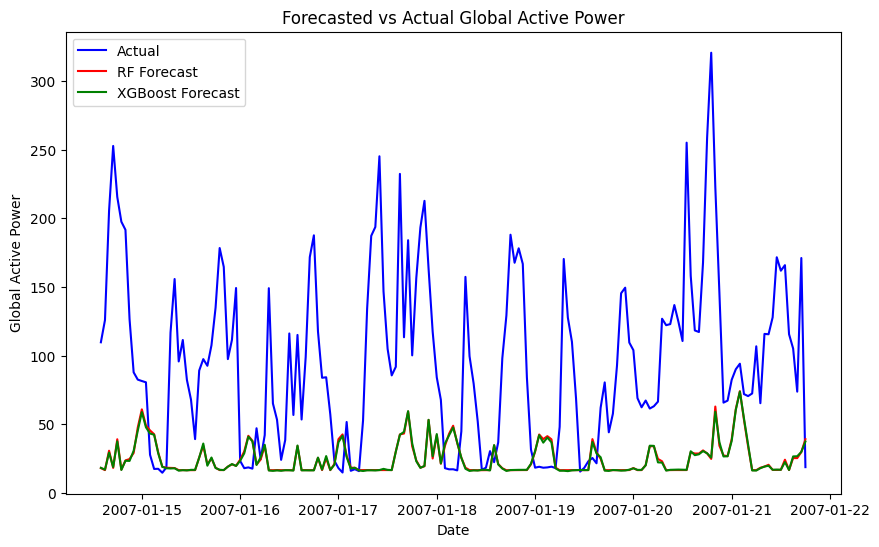

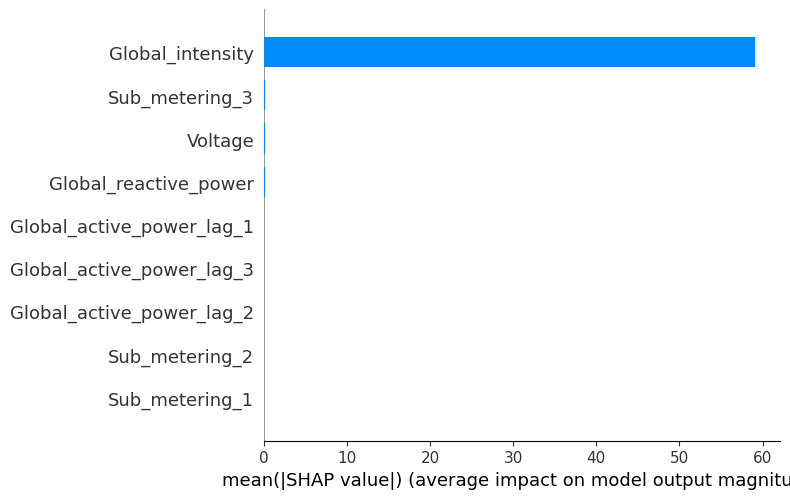

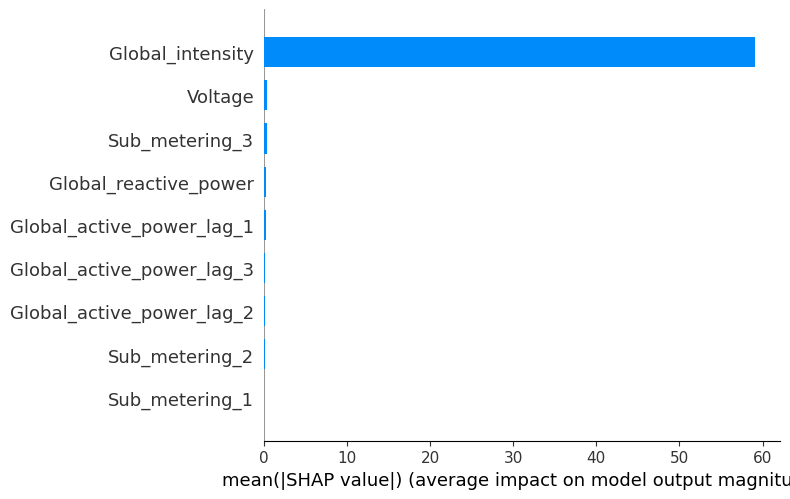

In [9]:
dataset_path = './data/subset_dataset_resampled.csv'
train_eval(dataset_path=dataset_path)

/home/vajradevam/Code/miniproject/VENV/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/vajradevam/Code/miniproject/VENV/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/vajradevam/Code/miniproject/VENV/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/vajradevam/Code/miniproject/VENV/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/vajradevam/Code/miniproject/VENV/lib/python3.12/site-packages/sklearn/utils/validation.py:2739

Random Forest - MSE: 4163.719651134758, RMSE: 64.526890914833, MAE: 47.66513785660392, MAPE: 67.25985448886127, R2: -1.1799072939783994
XGBoost - MSE: 4316.338809873808, RMSE: 65.69884938013608, MAE: 49.003390448972915, MAPE: 69.99958368631712, R2: -1.25981075655793


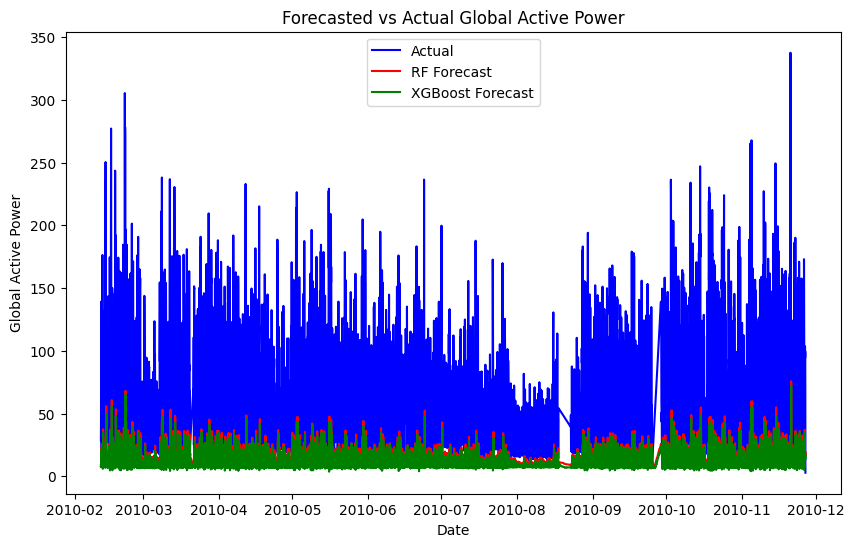

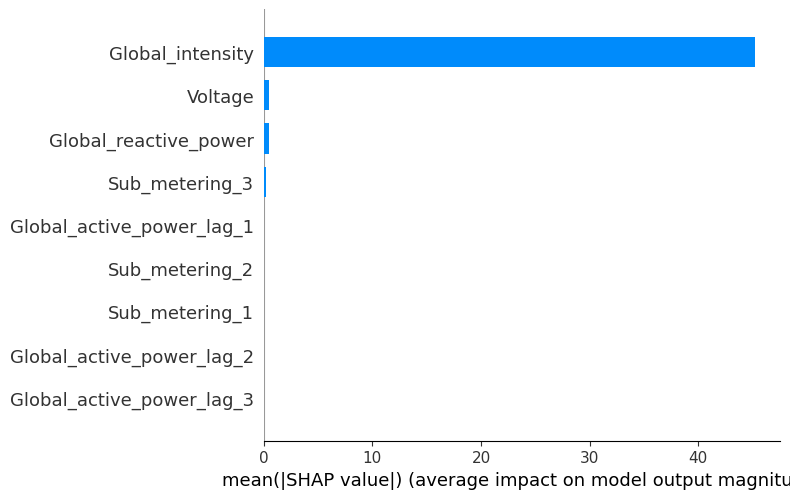

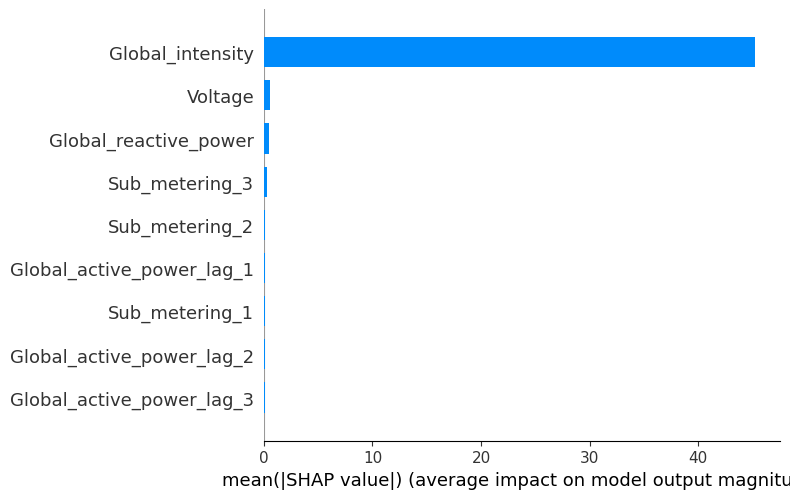

In [10]:
dataset_path = './data/dataset_resampled.csv'
train_eval(dataset_path=dataset_path)